<a href="https://colab.research.google.com/github/marktfaust/Linear-Classifiers-Feedforward-Neural-Networks/blob/main/Mark_Faust_DL_Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework \#2: Linear Classifiers and Feedforward Neural Networks  (37 Total Points)

In this homework assignment, we will (1) implement a linear model for classification (i.e. categorical regression), (2) implement evaluation metrics like accuracy, prediction, recall, and F1 score, implement a one-hidden-layer neural network, using both (3) manual backpropagation and (4) autodiff supported backpropagation.  Lastly, we will use a held-out validation set to choose the appropriate number of hidden units (5) and layers (6).

Let's start by importing the usual libraries: NumPy and Matplotlib.  We will also import [SciKit Learn](https://https://scikit-learn.org/stable/index.html), as it allows us to load the synthetic data set on which we will train our models.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

## Loading and Visualizing the Data
Let's first load and visualize the data on which we will be training the models.  We will have a small dataset of only 15 points.

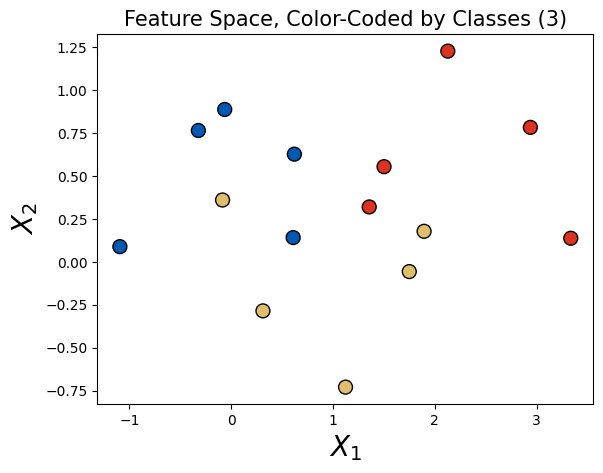

In [3]:
# Create a dataset with three crescent-moon-shaped clusters
def make_three_moons(n_samples=300, noise=0.15, random_state=42):
    X, y = make_moons(n_samples=n_samples // 3 * 2, noise=noise, random_state=random_state)

    # Extract one class and rotate it to create a third class
    X_class_1 = X[y == 1]
    theta = np.pi
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    X_rotated = X_class_1 @ rotation_matrix

    # Shift the new class
    X_rotated = X_rotated + np.array([3.25, .5])  # Shift up and to the right

    # Create new labels
    y_rotated = np.full(len(X_rotated), 2)

    # Combine original and new data
    X_new = np.vstack([X, X_rotated])
    y_new = np.hstack([y, y_rotated])

    # shuffle so that the 3rd class isn't always at the end
    index = np.arange(X_new.shape[0])
    np.random.shuffle(index)

    return X_new[index], y_new[index]

# Generate the training set
X, y = make_three_moons(n_samples=15)
n_classes = 3

# Visualize the features and color-code by the class assignments
colors = {0: '#005AB5', 1: '#E1BE6A', 2: '#DC3220'}
plt.scatter(X[:, 0], X[:, 1], c=[colors[y_idx] for y_idx in y], s=100, edgecolor='k')
plt.title("Feature Space, Color-Coded by Classes (3)", fontsize=15)
plt.xlabel("$X_1$", fontsize=20)
plt.ylabel("$X_2$", fontsize=20)
plt.show()

## (1) Implementing a Linear Classifier (3 points)
Now let's implement a classifier for this data and start with a relatively simple model, although we will re-use much of our code for building neural networks.

Let's import JAX to get started, but note for now, we will only be using its autodiff capabilities to test our manual solutions.

In [4]:
import jax.numpy as jnp
from jax import grad

Next we will define two crucial functions: the softmax inverse link function and the categorical cross-entropy function.

In [5]:
def softmax(z):
    exp_z = jnp.exp(z)
    return exp_z / jnp.sum(exp_z, axis=1, keepdims=True)

def cat_cross_entropy_loss(Y, class_probs):
    return jnp.mean(jnp.sum(-Y * jnp.log(class_probs + 1e-8), axis=1))

Now we need to define the crucial function that computes the gradient with which we can implement gradient descent.  For the model $$ \mathbb{E}[\mathbf{y} | \mathbf{x}] \ = \ \boldsymbol{\pi} \ = \  \text{softmax}(\mathbf{W}^{T} \mathbf{x}),$$ where $\boldsymbol{\pi}$ is the categorical distribution's parameters and $W \in \mathbb{R}^{D \times K}$ is a matrix of parameters (weights), compute the gradient of the categorical cross-entropy function w.r.t. $\mathbf{W}$: $$\nabla_{\mathbf{W}} \ell(\mathbf{W}; D),$$ where $\ell$ is the categorical cross entropy function and $D$ is the training data.  See [Section 2.3 of the course notes](https://https://enalisnick.github.io/Deep_Learning_Course_Notes.pdf#page=19.47) if you need reminded of the gradient derivation / equations.  

HINT: While I have written in the model above with the features as being a vector (like in class and in the notes), given an $N \times D$ feature *matrix*, it's computationally more efficient to implement the model as: $$ \mathbb{E}[\mathbf{Y} | \mathbf{X}] \ = \ \boldsymbol{\Pi} \ = \  \text{softmax}(\mathbf{X}\mathbf{W}),$$ where $\boldsymbol{\Pi}$ is an $N \times K$ matrix of class probabilities, $\mathbf{X}$ is a $N \times D$ matrix of features, and $\mathbf{W}\in \mathbb{R}^{D \times K}$ is the same as above.

In [6]:
def compute_gradient_linear_model(X, Y, weights):
  ### HW POINTS: 3
  ### Input ###
  # X: N x D matrix of features
  # Y: N x K matrix of one-hot encoded labels
  # weights: D x K matrix of model parameters
  ### Output ###
  # return a (DxK)-sized matrix of gradients
  ##############
  # assert data shape preconditions for matrix calculations
  assert(X.shape[0] == Y.shape[0])
  assert(Y.shape[1] == weights.shape[1])
  # compute class probabilities
  PI = softmax(jnp.dot(X, weights))
  # compute gradient from feature vectors
  gradient = (1/X.shape[0]) * X.T @ (PI - Y)
  # return D x K gradient matrix
  return gradient

Before moving on, let's check if the implementation is correct by comparing it to the autodiff result.

In [7]:
# define training loss for autograd
def train_loss_linear_model(weights, X, Y):
  class_probs = softmax(jnp.dot(X, weights))
  return cat_cross_entropy_loss(Y, class_probs)

# sample some random weights
weights = np.random.normal(size=(X.shape[1], n_classes))

# convert y labels to one-hot-encoded matrix
Y_one_hot = jnp.eye(n_classes)[y]

# compute gradients
manual_grad_w = compute_gradient_linear_model(X, Y_one_hot, weights)
auto_grad_w = grad(train_loss_linear_model)(weights, X, Y_one_hot)

# check if the gradient vectors are close; if so, test passes
print("Are the gradient vectors equal (approximately, up to 1e-3)?")
print(jnp.allclose(auto_grad_w, manual_grad_w, rtol=.001))

Are the gradient vectors equal (approximately, up to 1e-3)?
True


If your test passes (i.e. 'True' is printed above), lets train the model and visualize the results.

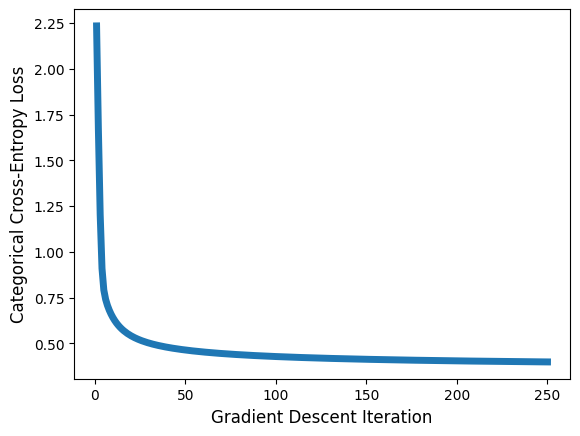

In [8]:
### TRAINING HYPERPARAMETERS FOR THE USER TO CONFIGURE ###
# stepsize for gradient descent
stepsize = 0.5

# maximum number of times to iterate the gradient update
max_iterations = 250
#################################################

# add ones to feature matrix to represent offset parameter
X_w_ones = jnp.c_[X, np.ones(X.shape[0])]

# initialize weights, scaling them by the number of input feature dimensions
weights = np.random.normal(size=(X_w_ones.shape[1], n_classes)) * jnp.sqrt(2./X_w_ones.shape[1])

# run gradient descent
losses = []
for i in range(max_iterations):
  gradient = compute_gradient_linear_model(X_w_ones, Y_one_hot, weights)
  weights -= stepsize * gradient
  losses.append(train_loss_linear_model(weights, X_w_ones, Y_one_hot))

# plot the training curve
plt.plot(range(1, max_iterations+1), losses, lw=5)
plt.xlabel("Gradient Descent Iteration", fontsize=12)
plt.ylabel("Categorical Cross-Entropy Loss", fontsize=12)
plt.show()

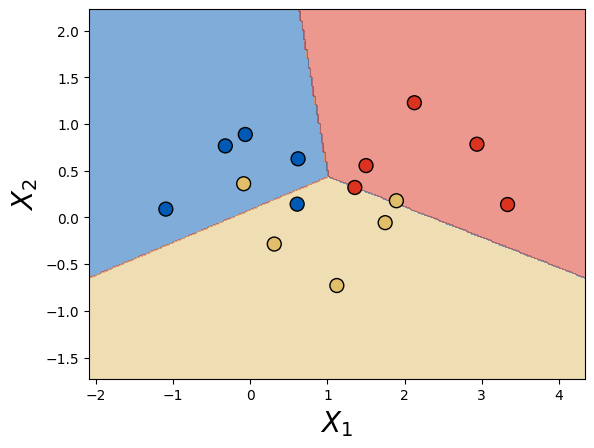

In [9]:
# Visualizing Decision Boundaries
def plot_decision_boundary(weights, X, y):
  # make feature grid
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = jnp.meshgrid(jnp.linspace(x_min, x_max, 300), jnp.linspace(y_min, y_max, 300))

  # compute predictions
  Z = softmax(jnp.dot(jnp.c_[xx.ravel(), yy.ravel(), jnp.ones(300*300)], weights))
  Z = jnp.argmax(Z, axis=1).reshape(xx.shape)

  # generate colors for data and classifier prediction regions
  plt.contourf(xx, yy, Z, levels=4, alpha=0.5, colors=[colors[0], colors[2], colors[1]])
  plt.scatter(X[:, 0], X[:, 1], c=[colors[y_idx] for y_idx in y], s=100, edgecolor='k')
  plt.xlabel("$X_1$", fontsize=20)
  plt.ylabel("$X_2$", fontsize=20)
  plt.show()


plot_decision_boundary(weights, X, y)

The resulting figure should look roughly like Figure 5 of the notes but with fewer data points.

## (2) Evaluating the Classifier (5 points)
Now that we have fit a classifier, let's examine just how good a model it is.  Below we will collect 500 additional data points that the model has never seen before.  This can be our test set (or validation set, if we choose to revise the model hyperparameters) to assess the performance of the model on held-out data.

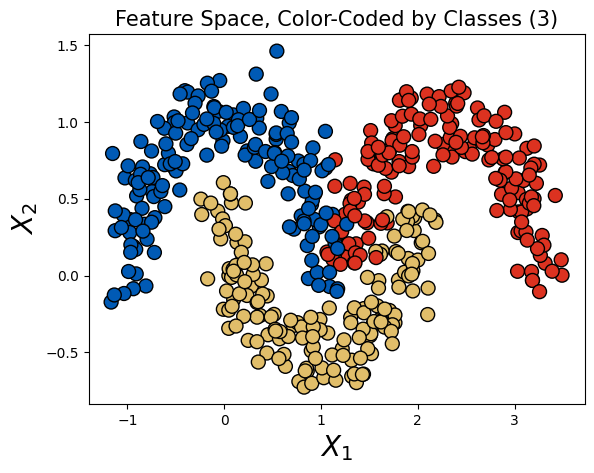

In [11]:
# Generate new points as a validation / test set
X_valid, y_valid = make_three_moons(n_samples=500)
Y_one_hot_valid = jnp.eye(n_classes)[y_valid]
X_w_ones_valid = jnp.c_[X_valid, np.ones(X_valid.shape[0])]


# Visualize the features and color-code by the class assignments
plt.scatter(X_valid[:, 0], X_valid[:, 1], c=[colors[y_idx] for y_idx in y_valid], s=100, edgecolor='k')
plt.title("Feature Space, Color-Coded by Classes (3)", fontsize=15)
plt.xlabel("$X_1$", fontsize=20)
plt.ylabel("$X_2$", fontsize=20)
plt.show()

Let's first implement *accuracy*; that is, the number of times the classifier makes the correct prediction out of the total number of predictions it makes (500, in this case, one for every validation point).

In [17]:
def compute_accuracy(y, predictions):
  #### HW POINTS: 1
  ### Input ###
  # y: M-sized array of true labels (integers)
  # predictions: M-sized array of predicted labels (integers)
  ### Output ###
  # real-valued scalar corresponding to accuracy
  ##############
  # count matching elements
  matches = np.sum(y == predictions)
  # total number of elements
  total = y.size
  # return accuracy, avoiding division by zero
  return (matches / total) if total > 0 else 0.0

#compute predictions on train set
train_class_probs = softmax(jnp.dot(X_w_ones, weights))
train_predictions = jnp.argmax(train_class_probs, axis=1)

# compute prediction on new data
valid_class_probs = softmax(jnp.dot(X_w_ones_valid, weights))
valid_predictions = jnp.argmax(valid_class_probs, axis=1)

# print results
print("Your implementation...")
print("Training Accuracy: %.1f %%" %(compute_accuracy(y, train_predictions)*100))
print("Validation Accuracy: %.1f %%" %(compute_accuracy(y_valid, valid_predictions)*100))

# check against SciKit Learn's built-in implementation
from sklearn.metrics import accuracy_score as skl_accuracy
print("\nSciKit Learn's implementation...")
print("Training Accuracy: %.1f %%" %(skl_accuracy(y, train_predictions)*100))
print("Validation Accuracy: %.1f %%" %(skl_accuracy(y_valid, valid_predictions)*100))

Your implementation...
Training Accuracy: 73.3 %
Validation Accuracy: 83.7 %

SciKit Learn's implementation...
Training Accuracy: 73.3 %
Validation Accuracy: 83.7 %


If your implementation matches SciKit Learn's, you can now move on to the next step: computing the confusion matrix.  Let's use Scikit Learn's built-in function to compute the confusion matrix on the validation data...

In [18]:
from sklearn.metrics import confusion_matrix

c_mat_valid = confusion_matrix(y_valid, valid_predictions)
print(c_mat_valid)

[[137  25   4]
 [ 18 131  17]
 [  0  17 149]]


Using this confusion matrix, implement functions to compute precision, recall, and the F1 score.  Recall that precision is the number of times the classifier makes the correct prediction out of the total times is makes that prediction.  Then average that values over all classes.  Recall is the number of times the classifier makes the correct prediction out of the total number of instances of that class.  Again, average over all classes.  Lastly, (macro) F1 score is the harmonic mean of precision and recall.

In [42]:
def compute_precision(confusion_mat):
  #### HW POINTS: 1
  ### Input ###
  # confusion_mat: KxK confusion matrix (with truth on the rows, preds on columns)
  ### Output ###
  # real-valued scalar corresponding to precision
  ##############
  # extract the diagonal elements (true positives for each class)
  C_k_k = jnp.diag(confusion_mat)
  # compute the sum of each column (total predicted positives for each class)
  column_sums = jnp.sum(confusion_mat, axis=0)
  # compute precision for each class, handling division by zero safely
  precisions = jnp.where(column_sums > 0, C_k_k / column_sums, 0.0)
  # compute and return macro precision (mean of per-class precision)
  return jnp.mean(precisions)

def compute_recall(confusion_mat):
  #### HW POINTS: 1
  ### Input ###
  # confusion_mat: KxK confusion matrix (with truth on the rows, preds on columns)
  ### Output ###
  # real-valued scalar corresponding to recall
  ##############
  # extract the diagonal elements (true positives for each class)
  C_k_k = jnp.diag(confusion_mat)
  # compute the sum of each row (total predicted positives for each class)
  row_sums = jnp.sum(confusion_mat, axis=1)
  # compute recall for each class, handling division by zero safely
  recalls = jnp.where(row_sums > 0, C_k_k / row_sums, 0.0)
  # compute and return macro recall (mean of per-class recall)
  return jnp.mean(recalls)


def compute_f1(confusion_mat):
  #### HW POINTS: 2
  ### Input ###
  # confusion_mat: KxK confusion matrix (with truth on the rows, preds on columns)
  ### Output ###
  # real-valued scalar corresponding to F1 score
  ##############
  # compute the macro precision of confusion matrix
  macro_precision = compute_precision(confusion_mat)
  # compute the macro recall of confusion matrix
  macro_recall = compute_recall(confusion_mat)
  # compute F1 score for confusion matrix
  f1 = 2 * (macro_precision * macro_recall)/(macro_precision + macro_recall)
  # return F1 score
  return f1

# print results
print("Your implementation...")
print("Validation Precision: %.3f" %(compute_precision(c_mat_valid)))
print("Validation Recall: %.3f" %(compute_recall(c_mat_valid)))
print("Validation F1 Score: %.3f" %(compute_f1(c_mat_valid)))

# check against SciKit Learn's built-in implementation
from sklearn.metrics import precision_score as skl_precision
from sklearn.metrics import recall_score as skl_recall
from sklearn.metrics import f1_score as skl_f1
print("\nSciKit Learn's implementation...")
print("Validation Precision: %.3f" %(skl_precision(y_valid, valid_predictions, average='macro')))
print("Validation Recall: %.3f" %(skl_recall(y_valid, valid_predictions, average='macro')))
print("Validation F1 Score: %.3f" %(skl_f1(y_valid, valid_predictions, average='macro')))

Your implementation...
Validation Precision: 0.839
Validation Recall: 0.837
Validation F1 Score: 0.838

SciKit Learn's implementation...
Validation Precision: 0.839
Validation Recall: 0.837
Validation F1 Score: 0.838


Admittedly, these precision, recall, and F1 scores are not so interesting in this case since the number of points assigned to each class is well-balanced.  These become increasingly important as classes become increasingly imbalanced.

## (3) Implementing a One-Hidden-Layer Neural Network (12 points)

Now we move on to define a more powerful model: a one-hidden layer neural network.  Let's start by implementing the non-linear activation function for the hidden units, the logistic function.

In [ ]:
# Non-linear activation function for hidden layer
def logistic_activation(z):
  return 1 / (1 + jnp.exp(-z))

Now let's implement the forward propagation of the neural network.  The hidden units will be computed as:
$$\mathbf{h} \ = \ \text{logistic}( \mathbf{W}_{0}^{T} \mathbf{x}) $$ where $x$ is a D-dimensional feature vector, $W_{0} \in \mathbb{R}^{D \times H}$ is weights that connect the input layer to the hidden layer, and logistic$(\cdot)$ is the logistic function applied element-wise to all $H$ hidden dimensions.  After computing the hidden units, the class probabilities will be compute simiarly to above: $$ \mathbb{E}[\mathbf{y} | \mathbf{x}] \ = \ \boldsymbol{\pi} \ = \  \text{softmax}(\mathbf{W}_{1}^{T} \mathbf{h}),$$ where $\mathbf{W}_{1} \in \mathbb{R}^{(H+1) \times K}$ is the matrix of parameters that connects the hidden layer to the output layer.  The first dimension is of size $H+1$ to account for the addition offset dimension that is added to the hidden layer.

HINT: Again, you'll likely find it to be more efficient to implement the weight multiplications as $\mathbf{H} \ = \ \text{logistic}(  \mathbf{X}\mathbf{W}_{0}) $ where $\mathbf{H} \in (0,1)^{N \times H}$ and $\mathbf{X} \in \mathbb{R}^{N \times D}$.  The hidden-to-output layer would follow the same format as for categorical linear regression, except $\mathbf{H}$ is now the 'feature' matrix.  Be sure to add a column on 1's to it to represent the offset parameter.

In [ ]:
def forward_prop_simple_nn(X, weights):
  ### HW POINTS: 6
  ### Input ###
  # X: N x D matrix of features
  # weights: list([D x H matrix, (H+1) x K matrix])
  ### Output ###
  # return: list([N x K matrix of class probs, N x (H+1) matrix of hidden units])
  ##############
  # YOUR SOLUTION GOES HERE #
  # compute hidden layer pre-activation
  # apply activation function
  # append column of ones for offset
  # compute output pre-activation
  # apply softmax transformation
  # return both the class probabilities *AND* the hidden represenation
  # return ???

Here will will implement the gradient calculation for both $\mathbf{W}_{0}$ and $\mathbf{W}_{1}$.  Your code should return a list with two elements, as shown below:
$$ \left[ \left(\nabla_{\mathbf{W}_{0}} \ell(\mathbf{W}_{0}, \mathbf{W}_{1}; D)\right)^{T}, \ \  \left(\nabla_{\mathbf{W}_{1}} \ell(\mathbf{W}_{0}, \mathbf{W}_{1}; D)\right)^{T} \right], $$ where $\ell$ is the categorical cross-entropy loss function.  That is, the first element should be the gradient for the input-to-hidden weights (re-oriented to match the orientation of $\mathbf{W}_{0}$), and the second element should be the gradient for the hidden-to-output weights.

In [ ]:
def compute_gradient_simple_nn(X, Y, weights):
  ### HW POINTS: 6
  ### Input ###
  # X: N x D matrix of features
  # Y: N x K matrix of one-hot labels
  # weights: list([D x H matrix, (H+1) x K matrix])
  ### Output ###
  # return: list([D x H gradient matrix, (H+1) x K gradient matrix])
  ##############
  # YOUR SOLUTION GOES HERE #
  # compute the forward propagation
  # compute d loss / d W1 (see linear model implementation)
  # compute d loss / d h
  # compute d h / d pre-activation
  # compute d pre-activation / d W0
  # return ???

Let's check the implementation against the gradients computed by autograd.

In [ ]:
# define training loss for autograd
def train_loss_simple_nn(weights, X, Y):
  class_probs = forward_prop_simple_nn(X, weights)[0]
  return cat_cross_entropy_loss(Y, class_probs)

# sample some random weights
n_hidden_units = 25
weights = [np.random.normal(size=(X.shape[1], n_hidden_units)),
           np.random.normal(size=(n_hidden_units + 1, n_classes))]


# compute gradients
manual_grad_w = compute_gradient_simple_nn(X, Y_one_hot, weights)
auto_grad_w = grad(train_loss_simple_nn)(weights, X, Y_one_hot)

# check if the gradient vectors are close; if so, test passes
print("Are the gradient vectors equal for the input-to-hidden weights (approximately, up to 1e-3)?")
print(jnp.allclose(auto_grad_w[0], manual_grad_w[0], rtol=.001))

print("Are the gradient vectors equal for the hidden-to-output weights (approximately, up to 1e-3)?")
print(jnp.allclose(auto_grad_w[1], manual_grad_w[1], rtol=.001))

In [ ]:
### TRAINING HYPERPARAMETERS FOR THE USER TO CONFIGURE ###
# number of hidden units in the neural network
n_hidden_units = 10

# stepsize for gradient descent
stepsize = 0.5

# maximum number of times to iterate the gradient update
max_iterations = 2500
#################################################

# initialize weights
weights = [np.random.normal(size=(X_w_ones.shape[1], n_hidden_units)) * jnp.sqrt(2./X_w_ones.shape[1]),
           np.random.normal(size=(n_hidden_units + 1, n_classes)) * jnp.sqrt(2./(n_hidden_units+1))]

# run gradient descent
losses = []
for i in range(max_iterations):
  gradient = compute_gradient_simple_nn(X_w_ones, Y_one_hot, weights)
  weights[0] -= stepsize * gradient[0]
  weights[1] -= stepsize * gradient[1]
  losses.append(train_loss_simple_nn(weights, X_w_ones, Y_one_hot))

# plot the training curve
plt.plot(range(1, max_iterations+1), losses, lw=5)
plt.xlabel("Gradient Descent Iteration", fontsize=12)
plt.ylabel("Categorical Cross-Entropy Loss", fontsize=12)
plt.show()

In [ ]:
# Visualizing Decision Boundaries
def plot_nn_decision_boundary(weights, X, y, forward_prop=forward_prop_simple_nn):
    # make feature grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = jnp.meshgrid(jnp.linspace(x_min, x_max, 300), jnp.linspace(y_min, y_max, 300))

    # compute predictions
    Z = forward_prop_simple_nn(jnp.c_[xx.ravel(), yy.ravel(), jnp.ones(300*300)], weights)[0]
    Z = jnp.argmax(Z, axis=1).reshape(xx.shape)

    # generate colors
    plt.contourf(xx, yy, Z, levels=4, alpha=0.5, colors=[colors[0], colors[2], colors[1]])
    plt.scatter(X[:, 0], X[:, 1], c=[colors[y_idx] for y_idx in y], s=100, edgecolor='k')
    plt.xlabel("$X_1$", fontsize=20)
    plt.ylabel("$X_2$", fontsize=20)
    plt.show()


plot_nn_decision_boundary(weights, X, y)

## (4) Implementing a Neural Network with an Arbitrary Depth (7 Points)
Now let's move on to a more powerful model still: a neural network with an arbitrary depth.  Fortunately, here we will use autograd to do the 'heavy lifting' of performing the gradient calculations.  Thus, we only need to implement the forward propagation of the model.  Specifically, it should implement for $l \in [1, L]$ hidden layers:
$$\mathbf{h}_{l} \ = \ \text{logistic}( \mathbf{W}_{l-1}^{T} \mathbf{h}_{l-1}) $$ where $\mathbf{h}_{0} = \mathbf{x}$, meaning that the first 'hidden layer' is just the original feature vector.  $\mathbf{h}_{L}$ should then be transformed one more time, with a $(H+1) \times K$ matrix, to get the input to the softmax transformation.  HINT: Do NOT hardcode the number of hidden layer.  In fact, you don't even need to pass the number of layers in as an argument.  Rather, let the data structure with which you store the weights implicitly encode the number of layers.

In [ ]:
def forward_prop_deep_nn(X, weights):
  ### HW POINTS: 5
  ### Input ###
  # X: N x D matrix of features
  # weights: list containing the NN's weight matrices in IN x OUT orientation
  ### Output ###
  # return: N x K matrix of class probabilities
  ##############
  # YOUR SOLUTION GOES HERE #
  # Loop:
  #   compute hidden layer pre-activation
  #   apply activation function
  #   append column of ones for offset
  # compute output pre-activation
  # apply softmax transformation
  # return ???

Let's check you solution via autograd again.  I've already defined the loss function for you below, which is just computing the class probabilities with you forward_prop function and putting them into the cross-entropy loss from above.

In [ ]:
# define training loss for autograd
def train_loss_deep_nn(weights, X, Y):
  class_probs = forward_prop_deep_nn(X, weights)
  return cat_cross_entropy_loss(Y, class_probs)

Now you need to implement the call to autograd to get the function that computes the gradients for an arbitrary number of weight matrices.

In [ ]:
### Use JAX to compute a function for the gradient for all weight parameters
### HW POINTS: 2
# compute_auto_gradient_deep_nn = ???

Finally, let's train the model with the code below.  Feel free to vary the hyperparameters, taking note of how the number of layers, hidden units, and gradient descent parameters affects the training time and outcome.

In [ ]:
### TRAINING HYPERPARAMETERS FOR THE USER TO CONFIGURE ###
# number of hidden units in the neural network
n_hidden_units = 10

# number of hidden layers in the neural network
n_hidden_layers = 1

# stepsize for gradient descent
stepsize = .5

# maximum number of times to iterate the gradient update
max_iterations = 2500
#################################################

### initialize weights
# input-to-hidden layer
weights = [ np.random.normal(size=(X_w_ones.shape[1], n_hidden_units)) * jnp.sqrt(1/X_w_ones.shape[1]) ]

# hidden-to-hidden layers
for n in range(n_hidden_layers-1):
  weights.append( np.random.normal(size=(n_hidden_units + 1, n_hidden_units)) * jnp.sqrt(1/(n_hidden_units + 1)) )

# hidden-to-output layer
weights.append( np.random.normal(size=(n_hidden_units + 1, n_classes)) * jnp.sqrt(1/(n_hidden_units + 1)) )

# run gradient descent
losses = []
for i in range(max_iterations):
  gradient = compute_auto_gradient_deep_nn(weights, X_w_ones, Y_one_hot)
  for n in range(len(weights)):
    weights[n] -= stepsize * gradient[n]
  losses.append(train_loss_deep_nn(weights, X_w_ones, Y_one_hot))

# plot the training curve
plt.plot(range(1, max_iterations+1), losses, lw=5)
plt.xlabel("Gradient Descent Iteration", fontsize=12)
plt.ylabel("Categorical Cross-Entropy Loss", fontsize=12)
plt.show()

In [ ]:
plot_nn_decision_boundary(weights, X, y, forward_prop=forward_prop_deep_nn)

## (5) Use Validation Set to Select the Number of Hidden Units (2 Points)
Now that we have a modular implementation that can support an arbitrary depth, we can address the question that always arises with neural networks: how should I set the architecture size?---meaning, the number of hidden units and hidden layers.  Let's first focus on the number of hidden units.  That is, the width of the hidden layer $\mathbf{h}$.  We will do this by cross-validating on a held-out validation set that was not used for training, checking the validation loss for each hidden unit configuration.

In [ ]:
import copy

### TRAINING HYPERPARAMETERS FOR THE USER TO CONFIGURE ###
# number of hidden units in the neural network
n_hidden_list = [1, 5, 10, 15]

# number of hidden layers in the neural network
n_hidden_layers = 1

# stepsize for gradient descent
stepsize = 0.5

# maximum number of times to iterate the gradient update
max_iterations = 2500
#################################################

training_losses = []
validation_losses = []

best_validation_loss = np.inf
best_weights = None

for n_hidden in n_hidden_list:

  ### initialize weights
  # input-to-hidden layer
  weights = [ np.random.normal(size=(X_w_ones.shape[1], n_hidden)) * jnp.sqrt(2./X_w_ones.shape[1]) ]

  # hidden-to-hidden layers
  for n in range(n_hidden_layers-1):
    weights.append( np.random.normal(size=(n_hidden + 1, n_hidden)) * jnp.sqrt(2./(n_hidden + 1)) )

  # hidden-to-output layer
  weights.append( np.random.normal(size=(n_hidden + 1, n_classes)) * jnp.sqrt(2./(n_hidden + 1)) )

  # run gradient descent
  for i in range(max_iterations):
    gradient = compute_auto_gradient_deep_nn(weights, X_w_ones, Y_one_hot)
    for n in range(len(weights)):
      weights[n] -= stepsize * gradient[n]

  # track loss on training and validation sets
  training_losses.append(train_loss_deep_nn(weights, X_w_ones, Y_one_hot))
  validation_losses.append(train_loss_deep_nn(weights, X_w_ones_valid, Y_one_hot_valid))

  # if loss is the best we've seen so far, save that value and the corresponding parameters
  if validation_losses[-1] < best_validation_loss:
    best_validation_loss = validation_losses[-1]
    best_weights = copy.deepcopy(weights)

Look at both the training and validation loss curves for each choice of hidden units.

In [ ]:
# plot the training and validation loss for each number of hidden units
plt.plot(n_hidden_list, validation_losses, 'rx-', lw=3, ms=10, label="Validation Loss")
plt.plot(n_hidden_list, training_losses, 'ko--', lw=3, ms=10, label="Training Loss")
plt.xlabel("Number of Hidden Units", fontsize=12)
plt.ylabel("Cross-Entropy Loss", fontsize=12)
plt.legend(fontsize=15)
plt.show()

Visualize the decision boundary and its alignment with the validation data as a sanity check.

In [ ]:
plot_nn_decision_boundary(best_weights, X_valid, y_valid, forward_prop=forward_prop_deep_nn)

**HOW MANY HIDDEN UNITS DID THE CROSS-VALIDATION PROCEDURE CHOOSE?** (2 Points)

[YOUR ANSWER HERE, EXPLAIN YOUR REASONING]
Note: There will be randomness in your answer, likely caused by the random initialization of the weights and your specific choice of training hyperparameters.  Thus, it is perfectly reasonable for two students to have different answers to the optimal number of hidden units.

## (6) Use Validation Set to Select the Number of Hidden Layers (8 Points)
For the final part of the assignment, repeat the process we did above but to select the number of hidden layers out of the given list of candidates below.  This time, you'll need to write the cross-validation implementation yourself.  Running for up to 5 hidden layers can take 10-15 mins to complete!---so test your code with a small number of hidden layers at first to keep your development cycle fast.

In [ ]:
## TRAINING HYPERPARAMETERS FOR THE USER TO CONFIGURE ###
# number of hidden units in the neural network
n_hidden_units = 3

# number of hidden layers in the neural network
n_hidden_layers_list = [1, 2, 3, 4, 5]

# stepsize for gradient descent
stepsize = 0.5

# maximum number of times to iterate the gradient update
max_iterations = 2500
#################################################
### HW POINTS: 6
###################################################
# YOUR SOLUTION GOES HERE #
# initialize data structures to track the losses
# Loop:
#  initialize weights
#  run gradient descent
#  track losses
#  save best parameter setting
###################################################

Plot the training and validation loss curves.

In [ ]:
# plot the training and validation loss for each number of hidden layers
plt.plot(n_hidden_layers_list, validation_losses, 'rx-', lw=3, ms=10, label="Validation Loss")
plt.plot(n_hidden_layers_list, training_losses, 'ko--', lw=3, ms=10, label="Training Loss")
plt.xlabel("Number of Hidden Layers", fontsize=12)
plt.ylabel("Cross-Entropy Loss", fontsize=12)
plt.legend(fontsize=15)
plt.show()

**HOW MANY HIDDEN LAYERS DID THE CROSS-VALIDATION PROCEDURE CHOOSE?** (2 Points)

[YOUR ANSWER HERE, EXPLAIN YOUR REASONING]
Note: Again, there will be randomness in your answer, likely caused by the random initialization of the weights and your specific choice of training hyperparameters.  Thus, it is perfectly reasonable for two students to have different answers to the optimal number of hidden layers.

## Turning in your Solutions

Turn in your solution via Gradescope (accessed through Canvas).  You need to upload *two* files:
*   a PDF of your code and solutions as shown in the notebook.  You can generate it via File > Print > Save as PDF.  Make sure all of your code and plotting cells are visible.
*   a Python file (file.py).  You can export one from the notebook via File > Download > Download .py.

